### Structures
Definition of basic structures for computational graph

In [1]:
abstract type GraphNode end
abstract type Operator <: GraphNode end

###MUTABLE 
mutable struct Constant{T} <: GraphNode
    output :: T
end

mutable struct Variable <: GraphNode
    output :: Any
    gradient :: Any
    name :: String
    Variable(output; name="?") = new(output, nothing, name)
end

mutable struct ScalarOperator{F} <: Operator
    inputs :: Any
    output :: Any
    gradient :: Any
    name :: String
    ScalarOperator(fun, inputs...; name="?") = new{typeof(fun)}(inputs, nothing, nothing, name)
end

mutable struct BroadcastedOperator{F} <: Operator
    inputs :: Any
    output :: Any
    gradient :: Any
    name :: String
    BroadcastedOperator(fun, inputs...; name="?") = new{typeof(fun)}(inputs, nothing, nothing, name)
end

### Pretty-printing
It helps tracking what happens

In [2]:
import Base: show, summary
show(io::IO, x::ScalarOperator{F}) where {F} = print(io, "op ", x.name, "(", F, ")");
show(io::IO, x::BroadcastedOperator{F}) where {F} = print(io, "op.", x.name, "(", F, ")");
show(io::IO, x::Constant) = print(io, "const ", x.output)
show(io::IO, x::Variable) = begin
    print(io, "var ", x.name);
    print(io, "\n ┣━ ^ "); summary(io, x.output)
    print(io, "\n ┗━ ∇ ");  summary(io, x.gradient)
end

show (generic function with 276 methods)

### Graph building
At first we have a set of loosely-coupled graph nodes. The following procedures build a proper graph!

In [3]:
function visit(node::GraphNode, visited, order)
    if node ∈ visited
    else
        push!(visited, node)
        push!(order, node)
    end
    return nothing
end
    
function visit(node::Operator, visited, order)
    if node ∈ visited
    else
        push!(visited, node)
        for input in node.inputs
            visit(input, visited, order)
        end
        push!(order, node)
    end
    return nothing
end

function topological_sort(head::GraphNode)
    visited = Set()
    order = Vector()
    visit(head, visited, order)
    return order
end

topological_sort (generic function with 1 method)

### Forward pass

In [4]:
reset!(node::Constant) = nothing
reset!(node::Variable) = node.gradient = nothing
reset!(node::Operator) = node.gradient = nothing

compute!(node::Constant) = nothing
compute!(node::Variable) = nothing
compute!(node::Operator) =
    node.output = forward(node, [input.output for input in node.inputs]...)

function forward!(order::Vector)
    for node in order
        compute!(node)
        reset!(node)
    end
    return last(order).output
end

forward! (generic function with 1 method)

### Backward pass

In [5]:
update!(node::Constant, gradient) = nothing
update!(node::GraphNode, gradient) = if isnothing(node.gradient)
    node.gradient = gradient else node.gradient .+= gradient
end

function backward!(order::Vector; seed=1.0)
    result = last(order)
    result.gradient = seed
    @assert length(result.output) == 1 "Gradient is defined only for scalar functions"
    for node in reverse(order)
        backward!(node)
    end
    return nothing
end

function backward!(node::Constant) end
function backward!(node::Variable) end
function backward!(node::Operator)
    inputs = node.inputs
    gradients = backward(node, [input.output for input in inputs]..., node.gradient)
    for (input, gradient) in zip(inputs, gradients)
        update!(input, gradient)
    end
    return nothing
end

backward! (generic function with 4 methods)

### Implemented operations
Below is the list of supported operations on graph nodes

#### Scalar operators

In [6]:
import Base: ^
^(x::GraphNode, n::GraphNode) = ScalarOperator(^, x, n)
forward(::ScalarOperator{typeof(^)}, x, n) = return x^n
backward(::ScalarOperator{typeof(^)}, x, n, g) = tuple(g * n * x ^ (n-1), g * log(abs(x)) * x ^ n)

backward (generic function with 1 method)

In [7]:
import Base: sin
sin(x::GraphNode) = ScalarOperator(sin, x)
forward(::ScalarOperator{typeof(sin)}, x) = return sin(x)
backward(::ScalarOperator{typeof(sin)}, x, g) = tuple(g * cos(x))

backward (generic function with 2 methods)

#### Broadcasted operators
The operations act on vectors of values so, the gradients are computed as vector-jacobian-products.

In [8]:
import Base: *
import LinearAlgebra: mul!, diagm
###diagm

# x * y (aka matrix multiplication)
*(A::GraphNode, x::GraphNode) = BroadcastedOperator(mul!, A, x)
forward(::BroadcastedOperator{typeof(mul!)}, A, x) = return A * x
backward(::BroadcastedOperator{typeof(mul!)}, A, x, g) = tuple(g * x', A' * g)

# x .* y (element-wise multiplication)
Base.Broadcast.broadcasted(*, x::GraphNode, y::GraphNode) = BroadcastedOperator(*, x, y)
forward(::BroadcastedOperator{typeof(*)}, x, y) = return x .* y
backward(node::BroadcastedOperator{typeof(*)}, x, y, g) = let
    𝟏 = ones(length(node.output))
    #####MOD BO NIE WIDZIAŁ diagm
    Jx = diagm(y .* 𝟏)
    Jy = diagm(x .* 𝟏)
    #####
    tuple(Jx' * g, Jy' * g)
end

backward (generic function with 4 methods)

In [9]:
Base.Broadcast.broadcasted(-, x::GraphNode, y::GraphNode) = BroadcastedOperator(-, x, y)
forward(::BroadcastedOperator{typeof(-)}, x, y) = return x .- y
backward(::BroadcastedOperator{typeof(-)}, x, y, g) = tuple(g,-g)

backward (generic function with 5 methods)

In [10]:
Base.Broadcast.broadcasted(+, x::GraphNode, y::GraphNode) = BroadcastedOperator(+, x, y)
forward(::BroadcastedOperator{typeof(+)}, x, y) = return x .+ y
backward(::BroadcastedOperator{typeof(+)}, x, y, g) = tuple(g, g)

backward (generic function with 6 methods)

In [11]:
import Base: sum
sum(x::GraphNode) = BroadcastedOperator(sum, x)
forward(::BroadcastedOperator{typeof(sum)}, x) = return sum(x)
backward(::BroadcastedOperator{typeof(sum)}, x, g) = let
    𝟏 = ones(length(x))
    J = 𝟏'
    tuple(J' * g)
end

backward (generic function with 7 methods)

In [12]:
Base.Broadcast.broadcasted(/, x::GraphNode, y::GraphNode) = BroadcastedOperator(/, x, y)
forward(::BroadcastedOperator{typeof(/)}, x, y) = return x ./ y
backward(node::BroadcastedOperator{typeof(/)}, x, y::Real, g) = let
    𝟏 = ones(length(node.output))
    Jx = diagm(𝟏 ./ y)
    Jy = (-x ./ y .^2)
    tuple(Jx' * g, Jy' * g)
end

backward (generic function with 8 methods)

In [13]:
import Base: max
Base.Broadcast.broadcasted(max, x::GraphNode, y::GraphNode) = BroadcastedOperator(max, x, y)
forward(::BroadcastedOperator{typeof(max)}, x, y) = return max.(x, y)
backward(::BroadcastedOperator{typeof(max)}, x, y, g) = let
    Jx = diagm(isless.(y, x))
    Jy = diagm(isless.(x, y))
    tuple(Jx' * g, Jy' * g)
end

backward (generic function with 9 methods)

# Neural network from scratch in Julia (with use of automatic differentiation)

In [14]:
# using Pkg
# Pkg.add("MLDatasets")
# Pkg.add("Plots")
# Pkg.add("Images")
# Pkg.add("CSV")
# Pkg.add("DataFrames")
# Pkg.add("BenchmarkTools")
# Pkg.add("UUIDs")

In [15]:
import MLDatasets: FashionMNIST
import Plots: plot, plot!, png, savefig
using Images
import CSV: read
import DataFrames: DataFrame
using BenchmarkTools
using UUIDs

## Data

In [16]:
function lib_data()
    train_xx, train_y = FashionMNIST.traindata(Float64);
    test_xx, test_y = FashionMNIST.testdata(Float64);
    global train_x = reshape(train_xx, (784, 60000))
    global test_x = reshape(test_xx, (784, 10000))
    global test_y
    global tr_n, tr_m = size(train_x)
    global ts_n, ts_m = size(test_x)

    global train_y = vectorize(train_y)
end

lib_data (generic function with 1 method)

In [17]:
function csv_data()
    #10k examples (784 pixels each)
    data_test = read("C:/Users/krukd/project_julia_net_scrath/fashion_mnist_test.csv", DataFrame)
    #60k examples (784 pixels each)
    data_train = read("C:/Users/krukd/project_julia_net_scrath/fashion_mnist_train.csv", DataFrame)
    data_test = Matrix{Float64}(data_test)
    data_train = Matrix{Float64}(data_train)

    tr_m, tr_n = size(data_train)
    ts_m, ts_n = size(data_test)


    data_test = data_test[1:ts_m,:]' #transponowanie po to, aby każda kolumna to był przykład
    global test_y = data_test[1,:]
    test_x = data_test[2:ts_n,:]
    global test_x = test_x / 255.

    data_train = data_train[1:tr_m, :]'
    train_y = data_train[1, :]
    train_x = data_train[2:tr_n, :]
    global train_x = train_x / 255.
    
    global train_y = vectorize(train_y)

    global tr_n, tr_m = size(train_x)
    global ts_n, ts_m = size(test_x)
end

csv_data (generic function with 1 method)

In [18]:
function vectorize(vec)
    N = 10
    len = length(vec)
    mtx = zeros(N, len)
    for i = 1:len
        mtx[Int64(vec[i])+1, i] = 1
    end
    return mtx
end

vectorize (generic function with 1 method)

In [19]:
@timed csv_data()

(value = (784, 10000), time = 26.1112457, bytes = 12056075043, gctime = 2.0574855, gcstats = Base.GC_Diff(12056075043, 1676, 0, 222848192, 958, 0, 2057485500, 37, 2))

In [20]:
@timed lib_data()

(value = [0.0 1.0 … 1.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 1.0 0.0 … 0.0 0.0], time = 1.9121107, bytes = 579345928, gctime = 0.3209855, gcstats = Base.GC_Diff(579345928, 8, 0, 1290218, 244, 0, 320985500, 1, 1))

## Neural network structure

### one hidden layer

In [21]:
function network_one_hidden_layer(net)
    #neural network
    #input layer
    global Wh1 = Variable(randn(net[2],net[1]), name="Wh1")
    #print(Wh1, "\n")
    global bh1 = Variable(randn(net[2]), name="bh1")
    #print(bh1, "\n")

    ###here is no hidden layer 

    #ouptup layer
    global Wo = Variable(randn(net[3],net[2]), name="Wo")
    #print(Wo, "\n")
    global bo = Variable(randn(net[3]), name="bo")
    #print(bo, "\n")
end

network_one_hidden_layer (generic function with 1 method)

### two hidden layer

In [22]:
function network_two_hidden_layer(net)
    #neural network
    #input layer
    global Wh1 = Variable(randn(net[2],net[1]), name="Wh1")
    #print(Wh1, "\n")
    global bh1 = Variable(randn(net[2]), name="bh1")
    #print(bh1, "\n")

    #hidden layer 
    global Wh2 = Variable(randn(net[3],net[2]), name="Wh2")
    #print(Wh2, "\n")
    global bh2 = Variable(randn(net[3]), name="bh2")
    #print(bh2, "\n")

    #ouptup layer
    global Wo = Variable(randn(net[4],net[3]), name="Wo")
    #print(Wo, "\n")
    global bo = Variable(randn(net[4]), name="bo")
    #print(bo, "\n")
end

network_two_hidden_layer (generic function with 1 method)

### some extra Base mods

In [23]:
# exp
import Base: exp
exp(x::GraphNode) = ScalarOperator(exp, x)
forward(::ScalarOperator{typeof(exp)},x) = return exp(x)
backward(::ScalarOperator{typeof(exp)},x,g) = tuple(g*exp(x))

backward (generic function with 10 methods)

In [24]:
# exp 'element wise'
Base.Broadcast.broadcasted(exp, x::GraphNode) = BroadcastedOperator(exp, x)
forward(::BroadcastedOperator{typeof(exp)}, x) = return exp.(x)
backward(node::BroadcastedOperator{typeof(exp)}, x, g) = tuple(g.*exp.(x))

backward (generic function with 11 methods)

In [25]:
Base.Broadcast.broadcasted(^, x::GraphNode, n::GraphNode) = BroadcastedOperator(^, x, n)
forward(::BroadcastedOperator{typeof(^)}, x, n) = return x .^ n
backward(node::BroadcastedOperator{typeof(^)}, x, n, g) = tuple(g .* n .* x .^ (n-1), g .* log.(abs.(x)) .* x .^ n)

backward (generic function with 12 methods)

In [26]:
import Base: <
<(x::GraphNode, y::GraphNode) = ScalarOperator(<, x, y)
forward(::ScalarOperator{typeof(<)}, x, y) = return x < y
backward(::ScalarOperator{typeof(<)}, x, y) = tuple(x < y)

backward (generic function with 13 methods)

In [27]:
Base.Broadcast.broadcasted(<, x::GraphNode, y::GraphNode) = BroadcastedOperator(<, x, y)
forward(::BroadcastedOperator{typeof(<)}, x, y) = return y .< y
backward(node::BroadcastedOperator{typeof(<)}, x, y) = tuple(x .< y)

backward (generic function with 14 methods)

### Activation functions

In [28]:
# Constant variables
one_half = Constant(0.5);
one_tenth = Constant(0.1);
two = Constant(2.0);
minus_one = Constant(-1.0);
one = Constant(1.0);
zero = Constant(0.0);

In [29]:
@inline σ(z) = (one .+ exp.(minus_one .* z)) .^ minus_one; #sigmoid activations function

In [30]:
@inline Leaky_Relu(z) = max.(one_tenth * z , z);

In [31]:
@inline softmax(z) = exp.(z) ./ sum(exp.(z));

### Network formulas

In [32]:
function formula_3_layers()
    global z1 = (Wh1 * x .+ bh1);
    global z1_activated = σ(z1); 
    global z2 = (Wo * z1_activated .+ bo);
    global ŷ = σ(z2);
    global E = sum(one_tenth .*((y .- ŷ).^ two));
end

formula_3_layers (generic function with 1 method)

In [33]:
function formula_3_layers_Relu_softmax()
    global z1 = (Wh1 * x .+ bh1);
    global z1_activated = Leaky_Relu(z1); 
    global z2 = (Wo * z1 .+ bo);
    global ŷ = softmax(z2);
    global E = sum(one_tenth .*((y .- ŷ).^ two));
end

formula_3_layers_Relu_softmax (generic function with 1 method)

In [34]:
function formula_4_layers()
    global z1 = (Wh1 * x .+ bh1);
    global z1_activated = σ(z1); 
    global z2 = (Wh2 * z1_activated .+ bh2);
    global z2_activated = σ(z2);
    global z3 = (Wo * z2_activated .+ bo);
    global ŷ = σ(z3);
    global E = sum(one_tenth .*((y .- ŷ).^ two));
end

formula_4_layers (generic function with 1 method)

In [35]:
function formula_4_layers_Relu_softmax()
    global z1 = (Wh1 * x .+ bh1);
    global z1_activated = Leaky_Relu(z1); 
    global z2 = (Wh2 * z1_activated .+ bh2);
    global z2_activated = Leaky_Relu(z2);
    global z3 = (Wo * z2_activated .+ bo);
    global ŷ = softmax(z3);
    global E = sum(one_tenth .*((y .- ŷ).^ two));
end

formula_4_layers_Relu_softmax (generic function with 1 method)

In [36]:
#graph = topological_sort(E)

In [37]:
#forward!(graph)

In [38]:
#backward!(graph)

### Gradient and weights updates

In [39]:
function update_gradient!(input, label)
    x.output = input; 
    y.output = label; 
    forward!(graph)
    backward!(graph)
    return nothing
end

update_gradient! (generic function with 1 method)

In [40]:
function update_weights_3_layers!(α)
    Wh1.output -= α .* Wh1.gradient
    bh1.output -= α .* bh1.gradient
    
    Wo.output -= α .* Wo.gradient
    bo.output -= α .* bo.gradient
    return nothing
end 

update_weights_3_layers! (generic function with 1 method)

In [41]:
function update_weights_4_layers!(α)
    Wh1.output -= α .* Wh1.gradient
    bh1.output -= α .* bh1.gradient

    Wh2.output -= α .* Wh2.gradient
    bh2.output -= α .* bh2.gradient
    
    Wo.output -= α .* Wo.gradient
    bo.output -= α .* bo.gradient
    return nothing
end 

update_weights_4_layers! (generic function with 1 method)

In [42]:
function batch_update_gradient_3_layers!(input, label)
    x.output = input; 
    y.output = label; 
    forward!(graph)
    backward!(graph)
    return Wh1.gradient, bh1.gradient, Wo.gradient, bo.gradient
end

batch_update_gradient_3_layers! (generic function with 1 method)

In [43]:
function batch_update_gradient_4_layers!(input, label)
    x.output = input; 
    y.output = label; 
    forward!(graph)
    backward!(graph)
    return Wh1.gradient, bh1.gradient, Wh2.gradient, bh2.gradient, Wo.gradient, bo.gradient
end

batch_update_gradient_4_layers! (generic function with 1 method)

In [44]:
function batch_update_weights_3_layers!(α, Wh1_g, bh1_g, Wo_g, bo_g)
    Wh1.output -= α .* Wh1_g
    bh1.output -= α .* bh1_g
    
    Wo.output -= α .* Wo_g
    bo.output -= α .* bo_g
    return nothing
end 

batch_update_weights_3_layers! (generic function with 1 method)

In [45]:
function batch_update_weights_4_layers!(α, Wh1_g, bh1_g, Wh2_g, bh2_g, Wo_g, bo_g)
    Wh1.output -= α .* Wh1_g
    bh1.output -= α .* bh1_g

    Wh2.output -= α .* Wh2_g
    bh2.output -= α .* bh2_g
    
    Wo.output -= α .* Wo_g
    bo.output -= α .* bo_g
    return nothing
end 

batch_update_weights_4_layers! (generic function with 1 method)

In [46]:
#update_gradient!(train_x[1:784], train_y[1:10])

In [47]:
#α = 0.4;

In [48]:
#update_weights_3_layers!(α)

### tests

In [49]:
onehot_to_fashion(y::Vector) = argmax(y) - 1

onehot_to_fashion (generic function with 1 method)

In [50]:
function predict_fashion(input)
    global x.output = input
    forward!(graph)
    onehot_to_fashion(ŷ.output)
end

predict_fashion (generic function with 1 method)

In [51]:
function tests_on_data(x, y)
    positive = 0
    for (i, col) in enumerate(eachcol(x))
        if predict_fashion(col) == y[i]
            positive = positive + 1
        end
    end
    return positive/length(test_y)
end

tests_on_data (generic function with 1 method)

# Core functions

In [52]:
function set_for_3_layers()
    network_one_hidden_layer([784, 10, 10])
    global x = Constant(train_x[1:784])
    global y = Constant(train_y[1:10]);
    formula_3_layers()
    global graph = topological_sort(E);
end

set_for_3_layers (generic function with 1 method)

In [53]:
function set_for_3_layers_with_Relu_softmax()
    network_one_hidden_layer([784, 10, 10])
    global x = Constant(train_x[1:784])
    global y = Constant(train_y[1:10]);
    formula_3_layers_Relu_softmax()
    global graph = topological_sort(E);
end

set_for_3_layers_with_Relu_softmax (generic function with 1 method)

In [54]:
function set_for_4_layers()
    network_two_hidden_layer([784, 10, 10, 10])
    global x = Constant(train_x[1:784])
    global y = Constant(train_y[1:10]);
    formula_4_layers()
    global graph = topological_sort(E);
end

set_for_4_layers (generic function with 1 method)

In [55]:
function set_for_4_layers_with_Relu_softmax()
    network_two_hidden_layer([784, 10, 10, 10])
    global x = Constant(train_x[1:784])
    global y = Constant(train_y[1:10]);
    formula_4_layers_Relu_softmax()
    global graph = topological_sort(E);
end

set_for_4_layers_with_Relu_softmax (generic function with 1 method)

### Single gradient/weights update

In [56]:
set_for_3_layers()
@timed update_gradient!(train_x[1:784], train_y[1:10])

(value = nothing, time = 3.72704, bytes = 393885576, gctime = 0.4439171, gcstats = Base.GC_Diff(393885576, 1, 0, 6718829, 1389, 0, 443917100, 1, 1))

In [57]:
@timed update_weights_3_layers!(1)    ####3 layers

(value = nothing, time = 0.3466755, bytes = 37227323, gctime = 0.0, gcstats = Base.GC_Diff(37227323, 2, 0, 679926, 459, 0, 0, 0, 0))

In [58]:
set_for_4_layers()
update_gradient!(train_x[1:784], train_y[1:10])
@timed update_weights_4_layers!(1)    ####4 layers

(value = nothing, time = 0.0001069, bytes = 130368, gctime = 0.0, gcstats = Base.GC_Diff(130368, 2, 0, 24, 0, 0, 0, 0, 0))

## Stochastic gradient descent (simple looping through data - weights update every gradient loop)

In [59]:
function stochastic_3_layers(α, data_number, epochs)
    global prec_history = []
    for e=1:epochs
        for (i, col) in enumerate(eachcol(train_x))
            j  = i * 10
            update_gradient!(col, train_y[j-9:j])
            update_weights_3_layers!(α)
        end 
        append!(prec_history, tests_on_data(test_x, test_y))
    end
end

stochastic_3_layers (generic function with 1 method)

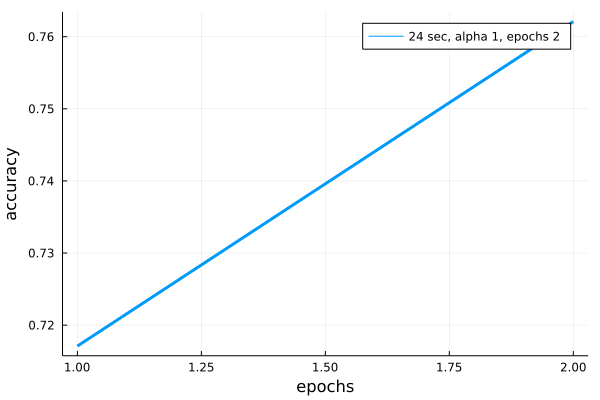

In [60]:
set_for_3_layers()
alpha = 1
epochs = 2
time_in_sec = @timed stochastic_3_layers(alpha, tr_m, epochs)
plot(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string(trunc(Int, time_in_sec.time), " sec, alpha ", alpha, ", epochs ", epochs), linewidth = 3)

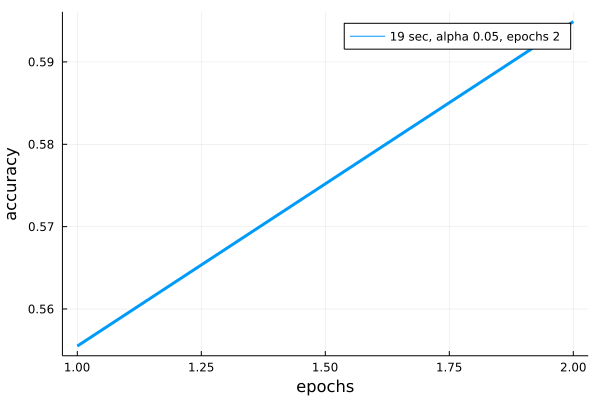

In [61]:
set_for_3_layers_with_Relu_softmax()
alpha = 0.05
epochs = 2
time_in_sec = @timed stochastic_3_layers(alpha, tr_m, epochs)
plot(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string(trunc(Int, time_in_sec.time), " sec, alpha ", alpha, ", epochs ", epochs), linewidth = 3)

In [62]:
function stochastic_4_layers(α, data_number, epochs)
    global prec_history = []
    for e=1:epochs
        for (i, col) in enumerate(eachcol(train_x))
            j  = i * 10
            update_gradient!(col, train_y[j-9:j])
            update_weights_4_layers!(α)
        end 
        append!(prec_history, tests_on_data(test_x, test_y))
    end
end

stochastic_4_layers (generic function with 1 method)

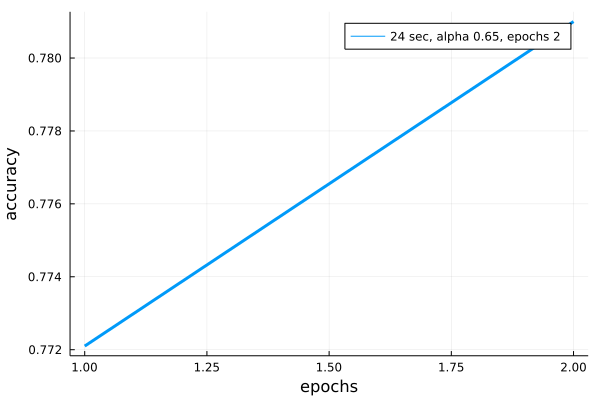

In [63]:
set_for_4_layers()
alpha = 0.65
epochs = 2
time_in_sec = @timed stochastic_4_layers(alpha, tr_m, epochs)
plot(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string(trunc(Int, time_in_sec.time), " sec, alpha ", alpha, ", epochs ", epochs), linewidth = 3)

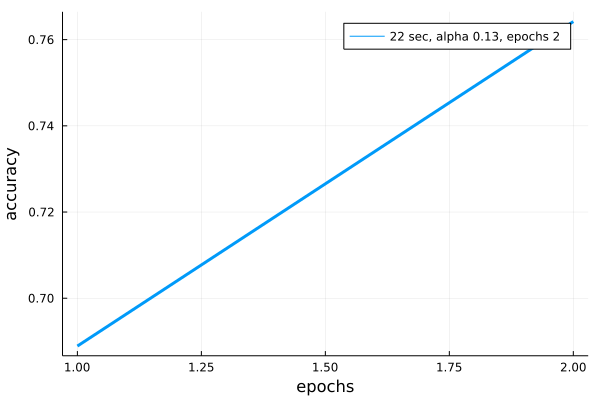

In [64]:
set_for_4_layers_with_Relu_softmax()
alpha = 0.13
epochs = 2
time_in_sec = @timed stochastic_4_layers(alpha, tr_m, epochs)
plot(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string(trunc(Int, time_in_sec.time), " sec, alpha ", alpha, ", epochs ", epochs), linewidth = 3)

In [65]:
function stochastic_tester(epochs)
    plot(title="Stochastic test")
    
    alpha = 1
    set_for_3_layers()
    time_in_sec = @timed stochastic_3_layers(alpha, tr_m, epochs)
    plot!(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string("Sigm-3l ", trunc(Int, time_in_sec.time), " sec, alpha ", alpha, ", epochs ", epochs), linewidth = 3)
    
    set_for_3_layers_with_Relu_softmax()
    alpha = 0.05
    time_in_sec = @timed stochastic_3_layers(alpha, tr_m, epochs)
    plot!(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string("Leaky_Relu_softmax-3l ", trunc(Int, time_in_sec.time), " sec, alpha ", alpha, ", epochs ", epochs), linewidth = 3, linestyle = :dash)
    
    set_for_4_layers()
    alpha = 0.65
    time_in_sec = @timed stochastic_4_layers(alpha, tr_m, epochs)
    plot!(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string("Sigm-4l ", trunc(Int, time_in_sec.time), " sec, alpha ", alpha, ", epochs ", epochs), linewidth = 3)

    set_for_4_layers_with_Relu_softmax()
    alpha = 0.13
    time_in_sec = @timed stochastic_4_layers(alpha, tr_m, epochs)
    plot!(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string("Leaky_Relu_softmax-4l ", trunc(Int, time_in_sec.time), " sec, alpha ", alpha, ", epochs ", epochs), linewidth = 3, linestyle = :dash)

    plot!(size=(1000,1000))
    plot!(dpi=400)
    plot!(grid = true)

    png(string("C:/Users/krukd/project_julia_net_scrath/plots/", "stochastic_plot_", uuid4()))
end

stochastic_tester (generic function with 1 method)

In [66]:
stochastic_tester(50)

In [67]:
function stochastic_3_l_tester(alpha_coef, alpha_step_num, epochs)
    plot(title="Stochastic alpha test")
    for alpha=1:alpha_step_num

        #println(plots_num)
        
        coef = alpha_coef
        alpha = round(alpha * (coef + (1/2*coef)) ;  digits = 3)
        epochs = epochs
        
        set_for_3_layers()
        time_in_sec = @timed stochastic_3_layers(alpha, tr_m, epochs)
        plot!(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string(trunc(Int, time_in_sec.time), " sec, alpha ", alpha, ", epochs ", epochs), linewidth = 3)
        
    end

    plot!(size=(1000,1000))
    plot!(dpi=400)
    plot!(grid = true)

    png(string("C:/Users/krukd/project_julia_net_scrath/plots/", "stochastic_plot_", uuid4()))
end

stochastic_3_l_tester (generic function with 1 method)

In [68]:
#alpha_coef, alpha_step_num, epochs
stochastic_3_l_tester(1, 5, 50)

## Full batch gradient descent (acumulating gradient with all amount of data before making an weights update)

In [69]:
function full_batch_gradient_descent_with_3_layers(α, data_number, epochs)
    global prec_history = []
    for a=1:epochs
        Wh1_sum = zeros(10, 784)
        bh1_sum = zeros(10,)
        Wo_sum = zeros(10, 10)
        bo_sum = zeros(10,)
        for (i, col) in enumerate(eachcol(train_x))
            j  = i * 10 
            aaaaa, bbbbb, ccccc, ddddd = batch_update_gradient_3_layers!(col, train_y[j-9:j])
            Wh1_sum = Wh1_sum .+ aaaaa
            bh1_sum = bh1_sum .+ bbbbb
            Wo_sum = Wo_sum .+ ccccc
            bo_sum = bo_sum .+ ddddd
        end
        batch_update_weights_3_layers!(α, Wh1_sum, bh1_sum, Wo_sum, bo_sum)
        append!(prec_history, tests_on_data(test_x, test_y))
    end 
end

full_batch_gradient_descent_with_3_layers (generic function with 1 method)

In [70]:
function full_batch_gradient_descent_with_4_layers(α, data_number, epochs)
    global prec_history = []
    for a=1:epochs
        Wh1_sum = zeros(10, 784)
        bh1_sum = zeros(10,)
        Wh2_sum = zeros(10, 10)
        bh2_sum = zeros(10,)
        Wo_sum = zeros(10, 10)
        bo_sum = zeros(10,)
        for (i, col) in enumerate(eachcol(train_x))
            j  = i * 10 
            aaaaa, bbbbb, ccccc, ddddd, eeeee, fffff = batch_update_gradient_4_layers!(col, train_y[j-9:j])
            Wh1_sum = Wh1_sum .+ aaaaa
            bh1_sum = bh1_sum .+ bbbbb
            Wh2_sum = Wh2_sum .+ ccccc
            bh2_sum = bh2_sum .+ ddddd          
            Wo_sum = Wo_sum .+ eeeee
            bo_sum = bo_sum .+ fffff

            global etet = bh1_sum 

        end
        batch_update_weights_4_layers!(α, Wh1_sum, bh1_sum, Wh2_sum, bh2_sum, Wo_sum, bo_sum)
        append!(prec_history, tests_on_data(test_x, test_y))
    end
end

full_batch_gradient_descent_with_4_layers (generic function with 1 method)

In [71]:
#alpha needs to be much lower than in previous examples because in weights update gradient is sum of gradient values  

#przy 50 epokach
#przy 0.0015 było jakieś 0.2 prec
#0015 > 001
#przy 0.001 było jakieś 0.35
#przy 0.0005 było jakieś 0.31 (ale wykres znacznie stabilniejszy, wygląda jakby jeszcze sporo mogło urosnąć)
#zajmuje ok 10 min

#przy 100 epokach
#przy 0.0008 było jakieś 0.55 - 16 min 

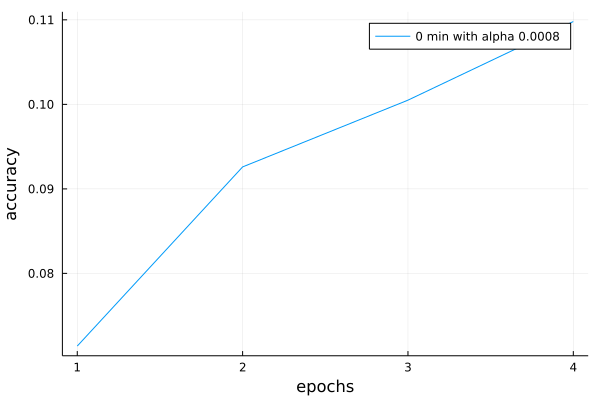

In [72]:
set_for_3_layers();
alpha = 0.0008
epochs = 4
time_in_sec = @timed full_batch_gradient_descent_with_3_layers(alpha, tr_m, epochs)
#plot_1 = plot(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string(trunc(Int, time_in_sec.time), " time in sec with alpha", alpha))
plot_1 = plot(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string(trunc(Int, time_in_sec.time/60), " min with alpha ", alpha))

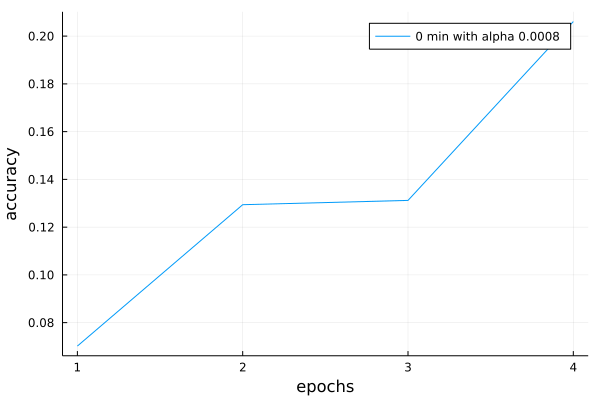

In [73]:
set_for_3_layers_with_Relu_softmax();
alpha = 0.0008
epochs = 4
time_in_sec = @timed full_batch_gradient_descent_with_3_layers(alpha, tr_m, epochs)
#plot_1 = plot(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string(trunc(Int, time_in_sec.time), " time in sec with alpha", alpha))
plot_1 = plot(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string(trunc(Int, time_in_sec.time/60), " min with alpha ", alpha))

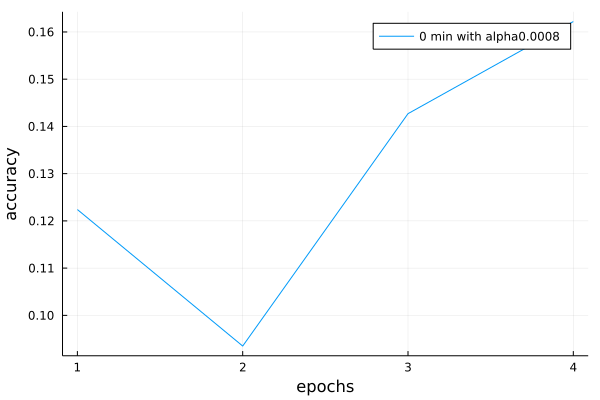

In [74]:
alpha = 0.0008
epochs = 4
set_for_4_layers();
time_in_sec = @timed full_batch_gradient_descent_with_4_layers(alpha, tr_m, epochs)
plot_3 = plot(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string(trunc(Int, time_in_sec.time/60), " min with alpha", alpha))

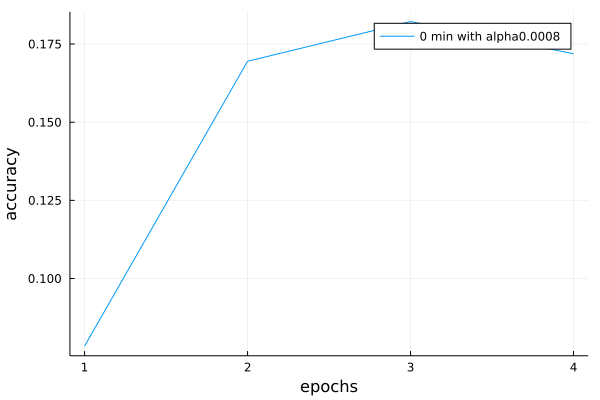

In [75]:
alpha = 0.0008
epochs = 4
set_for_4_layers_with_Relu_softmax();
time_in_sec = @timed full_batch_gradient_descent_with_4_layers(alpha, tr_m, epochs)
plot_3 = plot(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string(trunc(Int, time_in_sec.time/60), " min with alpha", alpha))

In [76]:
function full_batch_tester(epochs, alpha)
    plot(title="full batch tester")
    
    #alpha = 0.0008
    set_for_3_layers()
    time_in_sec = @timed full_batch_gradient_descent_with_3_layers(alpha, tr_m, epochs)
    plot!(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string("Sigm-3l ", trunc(Int, time_in_sec.time/60), " sec, alpha ", alpha, ", epochs ", epochs), linewidth = 3)
    
    set_for_3_layers_with_Relu_softmax()
    #alpha = 0.0008
    time_in_sec = @timed full_batch_gradient_descent_with_3_layers(alpha, tr_m, epochs)
    plot!(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string("Leaky_Relu_softmax-3l ", trunc(Int, time_in_sec.time/60), " sec, alpha ", alpha, ", epochs ", epochs), linewidth = 3, linestyle = :dash)
    
    set_for_4_layers()
    #alpha = 0.0008
    time_in_sec = @timed full_batch_gradient_descent_with_4_layers(alpha, tr_m, epochs)
    plot!(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string("Sigm-4l ", trunc(Int, time_in_sec.time/60), " sec, alpha ", alpha, ", epochs ", epochs), linewidth = 3)

    set_for_4_layers_with_Relu_softmax()
    #alpha = 0.0008
    time_in_sec = @timed full_batch_gradient_descent_with_4_layers(alpha, tr_m, epochs)
    plot!(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string("Leaky_Relu_softmax-4l ", trunc(Int, time_in_sec.time/60), " sec, alpha ", alpha, ", epochs ", epochs), linewidth = 3, linestyle = :dash)

    plot!(size=(1000,1000))
    plot!(dpi=400)
    plot!(grid = true)

    png(string("C:/Users/krukd/project_julia_net_scrath/plots/", "full_batch_plot_", uuid4()))
end

full_batch_tester (generic function with 1 method)

In [77]:
#epochs, alpha
#full_batch_tester(2, 0.0008)

## Mini batch gradient descent (acumulating gradient with some amount of data before making an weights update)

In [78]:
import Random: shuffle, shuffle!, seed!

In [79]:
function data_shuffle()
    shuffled = shuffle(1:size(train_x, 2))
    train_x_shuffled = zeros(size(train_x))
    train_y_shuffled = zeros(size(train_y))
    for i=1:length(shuffled)
        train_x_shuffled[:,shuffled[i]] .= train_x[:,i]
        train_y_shuffled[:,shuffled[i]] .= train_y[:,i]
    end
end

data_shuffle (generic function with 1 method)

In [80]:
function mini_batch_gradient_descent_with_3_layers(α, data_number, epochs, batch_size)  
    global prec_history = []
    for a=1:epochs

        shuffled = shuffle(1:size(train_x, 2))
        train_x_shuffled = zeros(size(train_x))
        train_y_shuffled = zeros(size(train_y))
        for i=1:length(shuffled)
            train_x_shuffled[:,shuffled[i]] .= train_x[:,i]
            train_y_shuffled[:,shuffled[i]] .= train_y[:,i]
        end
        
        Wh1_sum = zeros(10, 784)
        bh1_sum = zeros(10,)
        Wo_sum = zeros(10, 10)
        bo_sum = zeros(10,)

        for (i, col) in enumerate(eachcol(train_x))
            
            j  = i * 10
            aaaaa, bbbbb, ccccc, ddddd = batch_update_gradient_3_layers!(col, train_y[j-9:j])
            Wh1_sum = Wh1_sum .+ aaaaa
            bh1_sum = bh1_sum .+ bbbbb
            Wo_sum = Wo_sum .+ ccccc
            bo_sum = bo_sum .+ ddddd

            global etet = bh1_sum 
            
            if i%batch_size == 0
                batch_update_weights_3_layers!(α, Wh1_sum, bh1_sum, Wo_sum, bo_sum)

                Wh1_sum = zeros(10, 784)
                bh1_sum = zeros(10,)
                Wo_sum = zeros(10, 10)
                bo_sum = zeros(10,)
                
            end

        end

        prec = tests_on_data(test_x, test_y)
        append!(prec_history, prec)
        #println("Epoch: ", a, " with prec: ", prec)
    
    end 
end

mini_batch_gradient_descent_with_3_layers (generic function with 1 method)

In [81]:
function mini_batch_gradient_descent_with_4_layers(α, data_number, epochs, batch_size)  
    global prec_history = []
    for a=1:epochs

        shuffled = shuffle(1:size(train_x, 2))
        train_x_shuffled = zeros(size(train_x))
        train_y_shuffled = zeros(size(train_y))
        for i=1:length(shuffled)
            train_x_shuffled[:,shuffled[i]] .= train_x[:,i]
            train_y_shuffled[:,shuffled[i]] .= train_y[:,i]
        end
        
        Wh1_sum = zeros(10, 784)
        bh1_sum = zeros(10,)
        Wh2_sum = zeros(10, 10)
        bh2_sum = zeros(10,)
        Wo_sum = zeros(10, 10)
        bo_sum = zeros(10,)

        for (i, col) in enumerate(eachcol(train_x))
            j  = i * 10 
            
            aaaaa, bbbbb, ccccc, ddddd, eeeee, fffff = batch_update_gradient_4_layers!(col, train_y[j-9:j])
            Wh1_sum = Wh1_sum .+ aaaaa
            bh1_sum = bh1_sum .+ bbbbb
            Wh2_sum = Wh2_sum .+ ccccc
            bh2_sum = bh2_sum .+ ddddd          
            Wo_sum = Wo_sum .+ eeeee
            bo_sum = bo_sum .+ fffff


            global etet = bh1_sum 

            if i%batch_size == 0
                batch_update_weights_4_layers!(α, Wh1_sum, bh1_sum, Wh2_sum, bh2_sum, Wo_sum, bo_sum)

                Wh1_sum = zeros(10, 784)
                bh1_sum = zeros(10,)
                Wh2_sum = zeros(10, 10)
                bh2_sum = zeros(10,)
                Wo_sum = zeros(10, 10)
                bo_sum = zeros(10,)
                
            end
        end

        prec = tests_on_data(test_x, test_y)
        append!(prec_history, prec)
    
    end 
end

mini_batch_gradient_descent_with_4_layers (generic function with 1 method)

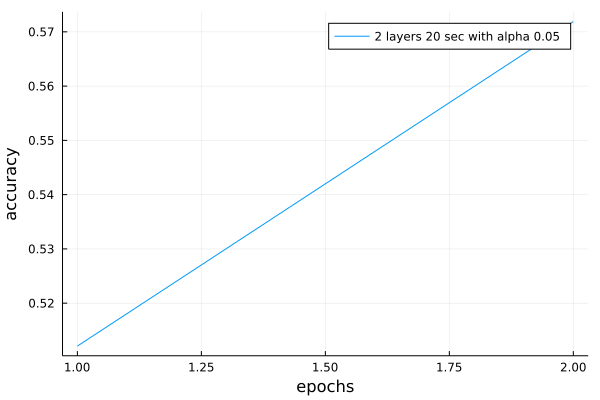

In [82]:
alpha = 0.05
epochs = 2
batch_size = 15
set_for_3_layers();
time_in_sec = @timed mini_batch_gradient_descent_with_3_layers(alpha, tr_m, epochs, batch_size)
plot_2 = plot(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string("2 layers " , trunc(Int, time_in_sec.time), " sec with alpha ", alpha))

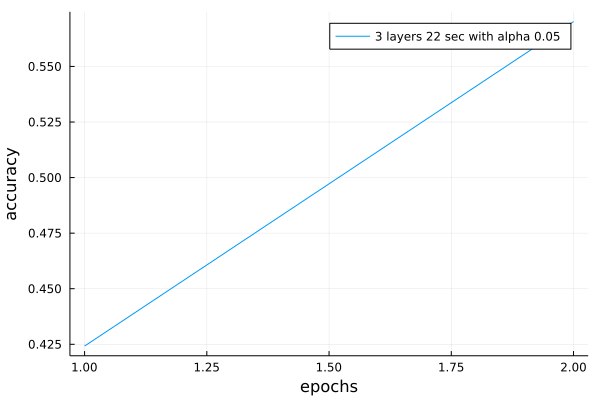

In [83]:
alpha = 0.05
epochs = 2
batch_size = 15
set_for_4_layers();
time_in_sec = @timed mini_batch_gradient_descent_with_4_layers(alpha, tr_m, epochs, batch_size)
plot_4 = plot(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string("3 layers ", trunc(Int, time_in_sec.time), " sec with alpha ", alpha))

In [84]:
function mini_batch_tester(epochs, alpha, batch_size)
    plot(title="mini batch test")
    
    #alpha = 0.0008
    set_for_3_layers()
    time_in_sec = @timed mini_batch_gradient_descent_with_3_layers(alpha, tr_m, epochs, batch_size)
    plot!(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string("Sigm-3l ", trunc(Int, time_in_sec.time), " sec, alpha ", alpha, ", epochs ", epochs), linewidth = 3)
    
    set_for_3_layers_with_Relu_softmax()
    #alpha = 0.0008
    time_in_sec = @timed mini_batch_gradient_descent_with_3_layers(alpha, tr_m, epochs, batch_size)
    plot!(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string("Leaky_Relu_softmax-3l ", trunc(Int, time_in_sec.time), " sec, alpha ", alpha, ", epochs ", epochs), linewidth = 3)
    
    set_for_4_layers()
    #alpha = 0.0008
    time_in_sec = @timed mini_batch_gradient_descent_with_4_layers(alpha, tr_m, epochs, batch_size)
    plot!(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string("Sigm-4l ", trunc(Int, time_in_sec.time), " sec, alpha ", alpha, ", epochs ", epochs), linewidth = 3)

    set_for_4_layers_with_Relu_softmax()
    #alpha = 0.0008
    time_in_sec = @timed mini_batch_gradient_descent_with_4_layers(alpha, tr_m, epochs, batch_size)
    plot!(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string("Leaky_Relu_softmax-4l ", trunc(Int, time_in_sec.time), " sec, alpha ", alpha, ", epochs ", epochs), linewidth = 3)

    plot!(size=(1000,1000))
    plot!(dpi=400)
    plot!(grid = true)

    png(string("C:/Users/krukd/project_julia_net_scrath/plots/", "mini_batch_plot_", uuid4()))
end

mini_batch_tester (generic function with 1 method)

In [85]:
#epochs, alpha, batch_size
mini_batch_tester(50, 0.1, 5)

In [117]:
function mini_batch_tester_sigm(alpha_coef, batch_size_coef, alpha_step_num, batch_size_step_num, epochs)
    plot(title="mini batch tester sigm")
    for alpha=1:alpha_step_num

        #println(plots_num)
        
        coef = alpha_coef
        alpha = round(alpha * (coef + (1*coef)) ;  digits = 3)
        epochs = epochs
        
        for batch_size=1:batch_size_step_num
            alpha = round(alpha * 0.5; digits = 3+batch_size)
            coef = batch_size_coef
            batch_size = trunc(Int, round(batch_size * (coef*500) ;  digits = 3))

            println(alpha, " ", batch_size)
            
            set_for_3_layers();
            time_in_sec = @timed mini_batch_gradient_descent_with_3_layers(alpha, tr_m, epochs, batch_size)
            plot_2 = plot!(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string("3 layers " , trunc(Int, time_in_sec.time), " sec with alpha ", alpha, " and batch_size ", batch_size), lw = 4)

            #set_for_4_layers();
            #time_in_sec = @timed mini_batch_gradient_descent_with_4_layers(alpha, tr_m, epochs, batch_size)
            #plot_4 = plot!(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string("4 layers ", trunc(Int, time_in_sec.time), " sec with alpha ", alpha, " and batch_size ", batch_size), linestyle = :dash, lw = 4)
            
        end
    end

    plot!(size=(1000,1000))
    plot!(dpi=400)
    plot!(grid = true)

    png(string("C:/Users/krukd/project_julia_net_scrath/plots/", "2_mini_two_plot_", uuid4()))
end

mini_batch_tester_sigm (generic function with 1 method)

In [122]:

                #alpha_coef, batch_size_coef, alpha_step_num, batch_size_step_num, epochs
mini_batch_tester_sigm(0.045,         10,                  2,              2,              25)

In [123]:

                #alpha_coef, batch_size_coef, alpha_step_num, batch_size_step_num, epochs
mini_batch_tester_sigm(0.045,         5,                  2,              2,              25)

0.045 2500
0.0225 5000
0.09 2500
0.045 5000


In [ ]:

                #alpha_coef, batch_size_coef, alpha_step_num, batch_size_step_num, epochs
mini_batch_tester_sigm(0.02,         10,                  2,              2,              25)

In [ ]:

                #alpha_coef, batch_size_coef, alpha_step_num, batch_size_step_num, epochs
mini_batch_tester_sigm(0.02,         5,                  2,              2,              25)

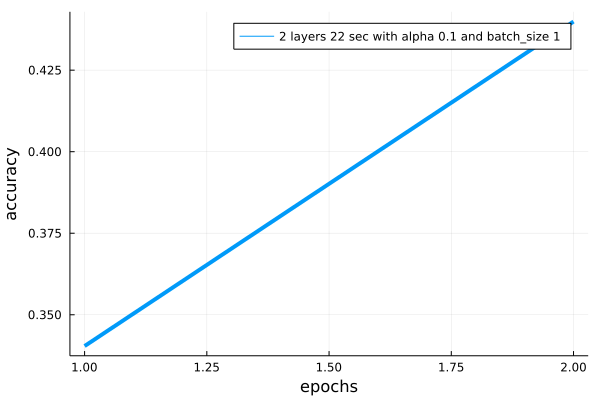

In [90]:
alpha = 0.1
epochs = 2
batch_size = 1
set_for_3_layers_with_Relu_softmax();
mini_batch_gradient_descent_with_3_layers(alpha, tr_m, epochs, batch_size)
plot(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string("2 layers " , trunc(Int, time_in_sec.time), " sec with alpha ", alpha, " and batch_size ", batch_size), lw = 4)

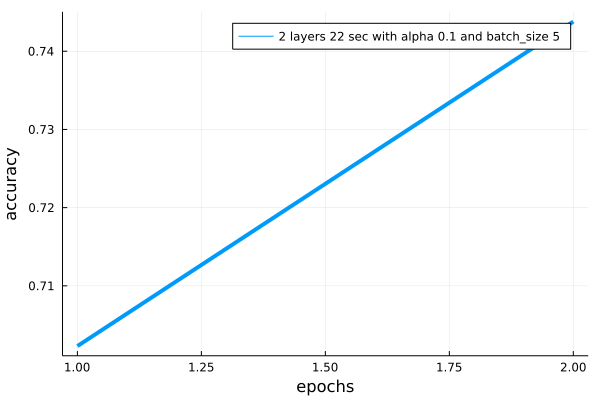

In [91]:
alpha = 0.1
epochs = 2
batch_size = 5
set_for_4_layers_with_Relu_softmax();
mini_batch_gradient_descent_with_4_layers(alpha, tr_m, epochs, batch_size)
plot(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string("2 layers " , trunc(Int, time_in_sec.time), " sec with alpha ", alpha, " and batch_size ", batch_size), lw = 4)

In [118]:
function mini_batch_tester_relu_softmax(alpha_coef, batch_size_coef, alpha_step_num, batch_size_step_num, epochs)
    plot(title="mini batch tester relu softmax")
    for alpha=1:alpha_step_num

        #println(plots_num)
        
        coef = alpha_coef
        alpha = round(alpha * (coef + (1*coef)) ;  digits = 3)
        epochs = epochs
        
        for batch_size=1:batch_size_step_num
            alpha = round(alpha * 0.5; digits = 3+batch_size)
            coef = batch_size_coef
            batch_size = trunc(Int, round(batch_size * (coef*1) ;  digits = 3))

            println(alpha, " ", batch_size)
            
            # set_for_3_layers_with_Relu_softmax();
            # time_in_sec = @timed mini_batch_gradient_descent_with_3_layers(alpha, tr_m, epochs, batch_size)
            # plot_2 = plot!(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string("3 layers " , trunc(Int, time_in_sec.time), " sec with alpha ", alpha, " and batch_size ", batch_size), lw = 4)

            set_for_4_layers_with_Relu_softmax();
            time_in_sec = @timed mini_batch_gradient_descent_with_4_layers(alpha, tr_m, epochs, batch_size)
            plot_4 = plot!(1:length(prec_history), prec_history, xlabel = "epochs", ylabel = "accuracy", label = string("4 layers ", trunc(Int, time_in_sec.time), " sec with alpha ", alpha, " and batch_size ", batch_size), linestyle = :dash, lw = 4)
            
        end
    end

    plot!(size=(1000,1000))
    plot!(dpi=400)
    plot!(grid = true)

    png(string("C:/Users/krukd/project_julia_net_scrath/plots/", "2_mini_two_plot_RELU", uuid4()))
end

mini_batch_tester_relu_softmax (generic function with 1 method)

In [119]:
                             #alpha_coef, batch_size_coef, alpha_step_num, batch_size_step_num, epochs
mini_batch_tester_relu_softmax(0.025,         10,                  2,              2,              25)

0.025 10
0.0125 20
0.05 10
0.025 20


In [121]:
                             #alpha_coef, batch_size_coef, alpha_step_num, batch_size_step_num, epochs
mini_batch_tester_relu_softmax(0.025,         5,                  2,              2,              25)

0.025 5
0.0125 10
0.05 5
0.025 10


### prediction with a little visualization

In [94]:
function show_img_from_test_data()
    #data -test or train data imported from MLDataSets (wejscia tam sa jeszcze macierzami 28x28)
    a = reshape(test_x[1:784]', 28, 28)
    colorview(Gray, a)
end 

show_img_from_test_data (generic function with 1 method)

In [95]:
function predict_with_img()
    println("image num: ", 1)
    println("Prediction: ", predict_fashion(test_x[1:784]))
    println("Actual label: ", argmax(test_y[1:10])-1)
    print("Actual label img:")
    show_img_from_test_data()
end 

predict_with_img (generic function with 1 method)

image num: 1
Prediction: 7
Actual label: 0
Actual label img:

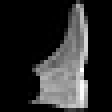

In [96]:
predict_with_img()